data cleaning


In [1]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("data/Data2.csv", encoding="utf-8")

print("Raw shape:", df_raw.shape)
df_raw.head()
#ahibhruth


Raw shape: (40, 23)


,event_id,industry,country,initiating_company,responding_company,event_date,source_name,source_url,action_type,action_description,...,quantity_after,response_observed,response_type,response_lag_days,no_response_outcome,market_share_change_estimated,public_sentiment_shift,market_structure,regulatory_sensitivity,notes
0,TIND_001,Telecom,India,Reliance Jio,Bharti Airtel; Vodafone Idea,2018-01-05,Economic Times,https://economictimes.indiatimes.com/news/comp...,Price reduction / data boost,Jio initiated price cuts across several prepai...,...,Standard,No,No response,0,NaN,Increase (for Jio),Positive for Jio,Oligopoly,No,Major disruptive price move; incumbents did no...
1,TIND_002,Telecom,India,Bharti Airtel,Reliance Jio,2018-06-12,ETTelecom / Economic Times,https://telecom.economictimes.indiatimes.com/n...,New plan / Data boost,Airtel launched new prepaid plans (₹149/₹399 w...,...,Standard,Yes,Alternative offer / data boost,0,NaN,Neutral,Neutral,Oligopoly,No,Same-day competitive data promotions.
2,TIND_003,Telecom,India,Reliance Jio,Bharti Airtel,2021-01-01,TelecomTalk / news sources,https://telecomtalk.info/airtel-unlimited-call...,Promotion / Free service (IUC removal),"Reliance Jio removed domestic IUC charges, eff...",...,Standard,Yes,Partial match / public assurance (Airtel empha...,0,NaN,Neutral,Neutral,Oligopoly,Yes,IUC removal is TRAI‑sensitive; incumbents publ...
3,TIND_004,Telecom,India,Bharti Airtel,Reliance Jio,2021-01-04,India Today / news sources,https://www.indiatoday.in/technology/news/stor...,Quantity increase (data),Airtel upgraded its ₹199 plan to offer 1.5GB/d...,...,Standard,Yes,Match,0,NaN,Neutral,Neutral,Oligopoly,No,Feature match to retain competitiveness.
4,TIND_005,Telecom,India,Bharti Airtel,Vodafone Idea; Reliance Jio,2021-11-26,Economic Times / Reuters,https://economictimes.indiatimes.com/industry/...,Tariff hike (price increase),Airtel announced ~20–25% tariff hikes on prepa...,...,Standard,Yes,Match,1,NaN,Neutral,Neutral/Negative for price-sensitive customers,Oligopoly,No,Coordinated industry tariff increases over a s...


In [2]:
df = df_raw.copy()


In [3]:
missing_values = ["NA", "N/A", "", "None", "null"]
df.replace(missing_values, np.nan, inplace=True)

df.isna().sum()


event_id                          0
industry                          0
country                           0
initiating_company                0
responding_company                1
event_date                        0
source_name                       0
source_url                       20
action_type                       0
action_description                0
price_before                      6
price_after                       3
quantity_before                   3
quantity_after                    0
response_observed                 0
response_type                     0
response_lag_days                 0
no_response_outcome              40
market_share_change_estimated     0
public_sentiment_shift            0
market_structure                  0
regulatory_sensitivity            0
notes                             0
dtype: int64

In [4]:
df["event_date"] = pd.to_datetime(
    df["event_date"],
    dayfirst=True,
    errors="coerce"
)


In [5]:
def yes_no_clean(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x == "yes":
        return 1
    if x == "no":
        return 0
    return np.nan

df["response_observed_bin"] = df["response_observed"].apply(yes_no_clean)
df["regulatory_sensitivity_bin"] = df["regulatory_sensitivity"].apply(yes_no_clean)

df[["response_observed", "response_observed_bin"]].head()


,response_observed,response_observed_bin
0,No,0
1,Yes,1
2,Yes,1
3,Yes,1
4,Yes,1


In [6]:
df["response_lag_days_num"] = pd.to_numeric(
    df["response_lag_days"],
    errors="coerce"
)


In [7]:
def price_type(x):
    if pd.isna(x):
        return "missing"
    x = str(x).lower()
    x = x.replace("â¥", "¥")  # encoding fix
    if "¥" in x:
        return "numeric"
    return x

df["price_before_type"] = df["price_before"].apply(price_type)
df["price_after_type"] = df["price_after"].apply(price_type)


In [8]:
df["quantity_after"] = df["quantity_after"].astype(str).str.lower().str.strip()

quantity_map = {
    "standard": 1,
    "bundle": 2,
    "seasonal": 3,
    "expanded": 4,
    "high speed": 4,
    "premium": 4
}

df["quantity_after_code"] = df["quantity_after"].map(quantity_map)


In [9]:
df["crisis_event"] = (
    df["notes"]
    .astype(str)
    .str.lower()
    .str.contains("covid|inflation|lockdown|tax")
)


In [10]:
text_cols = [
    "industry",
    "action_type",
    "response_type",
    "market_structure",
    "public_sentiment_shift"
]

for col in text_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()


In [11]:
df.info()

df["response_type"].value_counts()
df["response_observed_bin"].value_counts(dropna=False)
df["response_lag_days_num"].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   event_id                       40 non-null     object        
 1   industry                       40 non-null     object        
 2   country                        40 non-null     object        
 3   initiating_company             40 non-null     object        
 4   responding_company             39 non-null     object        
 5   event_date                     23 non-null     datetime64[ns]
 6   source_name                    40 non-null     object        
 7   source_url                     20 non-null     object        
 8   action_type                    40 non-null     object        
 9   action_description             40 non-null     object        
 10  price_before                   34 non-null     object        
 11  price_after          

count    40.000000
mean     12.175000
std      23.647939
min       0.000000
25%       0.000000
50%       0.000000
75%      14.000000
max      90.000000
Name: response_lag_days_num, dtype: float64

In [12]:
df.to_csv("data/cleaned2_dataset.csv", index=False)
print("✅ Cleaned dataset saved to data/cleaned_dataset.csv")


✅ Cleaned dataset saved to data/cleaned_dataset.csv


In [13]:
df["response_type"].value_counts()
df["response_observed_bin"].value_counts(dropna=False)
df["price_before_type"].value_counts()


price_before_type
neutral       14
missing        6
₹350           4
standard       4
10% points     3
premium        2
₹600           1
₹400           1
₹550           1
₹380           1
₹426           1
₹387           1
₹468           1
Name: count, dtype: int64

EDA

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/cleaned2_dataset.csv")


In [52]:
df.shape


(40, 28)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   event_id                       40 non-null     object
 1   industry                       40 non-null     object
 2   country                        40 non-null     object
 3   initiating_company             40 non-null     object
 4   responding_company             40 non-null     object
 5   event_date                     40 non-null     object
 6   source_name                    40 non-null     object
 7   action_type                    40 non-null     object
 8   action_description             40 non-null     object
 9   price_before                   40 non-null     object
 10  price_after                    40 non-null     object
 11  quantity_before                40 non-null     object
 12  quantity_after                 40 non-null     object
 13  respons

In [54]:
df["response_type"].value_counts()


response_type
competitive response                                                                       10
competitive reaction                                                                       10
match                                                                                       4
no response                                                                                 3
alternative offer / data boost                                                              1
alternative offer (planned)                                                                 1
alternative products / distribution push                                                    1
partial match / public assurance (airtel emphasized no change in its unlimited calling)     1
alternative strategy (coke focused on distribution and ₹10 returnable glass bottles)        1
match (price-point introduction)                                                            1
alternative marketing campaign                

In [55]:
pd.crosstab(
    df["action_type"],
    df["response_type"],
    normalize="index"
)


response_type,5g rollout acceleration,alternative bundled plans,alternative marketing campaign,alternative offer (planned),alternative offer / data boost,alternative products / distribution push,alternative strategy (coke focused on distribution and ₹10 returnable glass bottles),channel incentives,competitive reaction,competitive response,distribution push,match,match (price-point introduction),new energy drink focus,no response,ott partnerships,partial match / public assurance (airtel emphasized no change in its unlimited calling)
action_type,,,,,,,,,,,,,,,,,
5g roaming launch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5g spectrum auction win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ad campaign / marketing,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ai-powered network ops,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bundled plans,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
covid relief measures,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
covid supply continuity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
distribution & brand strategy,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
distribution expansion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


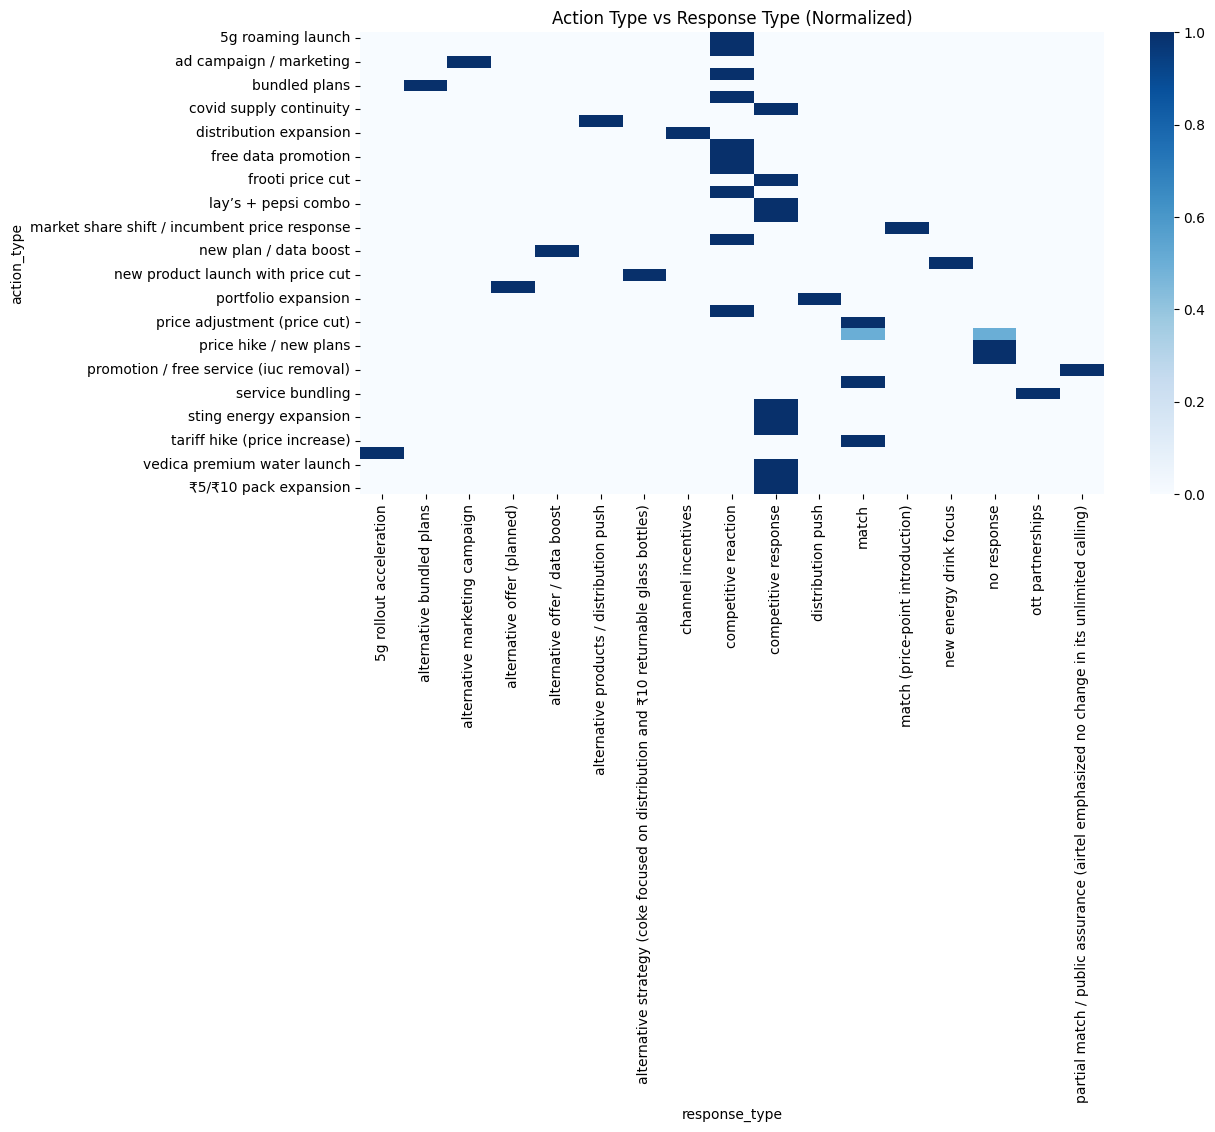

In [56]:
plt.figure(figsize=(12,6))
sns.heatmap(
    pd.crosstab(df["action_type"], df["response_type"], normalize="index"),
    cmap="Blues",
    annot=False
)
plt.title("Action Type vs Response Type (Normalized)")
plt.show()


In [57]:
pd.crosstab(df["crisis_event"], df["response_type"], normalize="index")


response_type,5g rollout acceleration,alternative bundled plans,alternative marketing campaign,alternative offer (planned),alternative offer / data boost,alternative products / distribution push,alternative strategy (coke focused on distribution and ₹10 returnable glass bottles),channel incentives,competitive reaction,competitive response,distribution push,match,match (price-point introduction),new energy drink focus,no response,ott partnerships,partial match / public assurance (airtel emphasized no change in its unlimited calling)
crisis_event,,,,,,,,,,,,,,,,,
False,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.25,0.25,0.025,0.1,0.025,0.025,0.075,0.025,0.025


In [58]:
df["response_lag_days_num"].describe()


count    40.000000
mean     12.175000
std      23.647939
min       0.000000
25%       0.000000
50%       0.000000
75%      14.000000
max      90.000000
Name: response_lag_days_num, dtype: float64

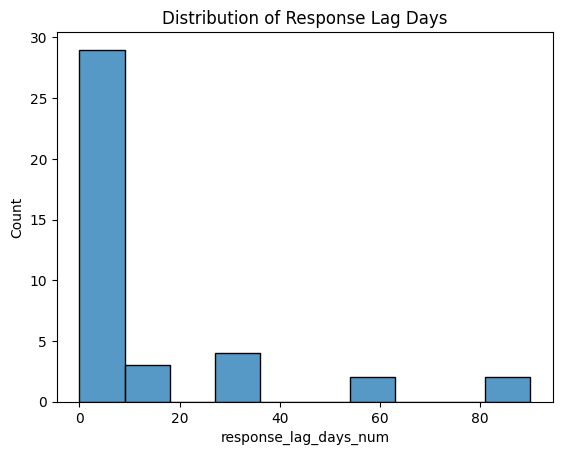

In [59]:
sns.histplot(df["response_lag_days_num"], bins=10)
plt.title("Distribution of Response Lag Days")
plt.show()


In [60]:
df["industry"].value_counts()


industry
telecom    20
fmcg       20
Name: count, dtype: int64

In [61]:
pd.crosstab(df["industry"], df["response_type"], normalize="index")


response_type,5g rollout acceleration,alternative bundled plans,alternative marketing campaign,alternative offer (planned),alternative offer / data boost,alternative products / distribution push,alternative strategy (coke focused on distribution and ₹10 returnable glass bottles),channel incentives,competitive reaction,competitive response,distribution push,match,match (price-point introduction),new energy drink focus,no response,ott partnerships,partial match / public assurance (airtel emphasized no change in its unlimited calling)
industry,,,,,,,,,,,,,,,,,
fmcg,0.00,0.00,0.05,0.05,0.00,0.05,0.05,0.05,0.0,0.5,0.05,0.05,0.05,0.05,0.05,0.00,0.00
telecom,0.05,0.05,0.00,0.00,0.05,0.00,0.00,0.00,0.5,0.0,0.00,0.15,0.00,0.00,0.10,0.05,0.05


ML

In [62]:
counts = df["response_type"].value_counts()
valid_types = counts[counts >= 2].index

df_ml = df[df["response_type"].isin(valid_types)].copy()

df_ml["response_type"].value_counts()


response_type
competitive response    10
competitive reaction    10
match                    4
no response              3
Name: count, dtype: int64

In [63]:
features = [
    "industry",
    "action_type",
    "price_before_type",
    "price_after_type",
    "quantity_after_code",
    "market_structure",
    "regulatory_sensitivity_bin",
    "crisis_event"
]

X = df_ml[features]
y = df_ml["response_type"]


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)


In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


In [66]:
categorical = [
    "industry",
    "action_type",
    "price_before_type",
    "price_after_type",
    "market_structure"
]

numeric = [
    "quantity_after_code",
    "regulatory_sensitivity_bin",
    "crisis_event"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)


In [67]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)


In [68]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


                      precision    recall  f1-score   support

competitive reaction       1.00      1.00      1.00         5
competitive response       1.00      1.00      1.00         1
               match       0.00      0.00      0.00         0
         no response       0.00      0.00      0.00         1

            accuracy                           0.86         7
           macro avg       0.50      0.50      0.50         7
        weighted avg       0.86      0.86      0.86         7

[[5 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 1 0]]


d:\POME\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\POME\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\POME\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\POME\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: 

In [70]:
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
importances = model.named_steps["clf"].feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


,feature,importance
49,num__regulatory_sensitivity_bin,0.107439
36,cat__price_after_type_neutral,0.076487
23,cat__price_before_type_neutral,0.069186
12,cat__action_type_price hike,0.064161
47,cat__market_structure_oligopoly,0.064034
21,cat__price_before_type_10% points,0.058642
0,cat__industry_fmcg,0.057562
1,cat__industry_telecom,0.057318
46,cat__market_structure_competitive,0.057298
24,cat__price_before_type_premium,0.048626
